<a href="https://colab.research.google.com/github/Matt-ctrl/ai-workshop-utm-july11/blob/main/Learning_Pytorch_UTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the dataset

- Usually, we can get the data either through:
 1. kaggle: https://www.kaggle.com/
 2. Huggingface: https://huggingface.co/datasets
 3. roboflow: https://public.roboflow.com/ (usually i used to get dataset for object detection)


So for this project, we get dataset from kaggle...

dataset we going to used:
2. Nasa airfoil dataset : https://www.kaggle.com/datasets/fedesoriano/airfoil-selfnoise-dataset
3. Mammal (but we only take 20%, since, some dont have high comnputing resources): https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals/data





## Helper Function to Download dataset


In this project, we only use datasets hosted on Google Drive. This is because we are working with a subset (approximately 20%) of the original datasets from Kaggle.

The reason for using a smaller portion is to ensure that all participants, regardless of their computing resources (e.g., not subscribed to Colab Pro/Plus), can run the code efficiently.

In [1]:
!pip install -q gdown #refer to doc https://github.com/wkentaro/gdown
!pip install rarfile

In [2]:
import os
from pathlib import Path

#setup path
#as for this we used this env storage
#but if you want to used your drive as storage you can change below
base_dataset_root_path = Path('')

#dataset root
dataset_mammals = base_dataset_root_path / 'dataset_mammals'
dataset_airFoilSelfNoise = base_dataset_root_path /'dataset_airFoilSelfNoise'
dataset_drone = base_dataset_root_path / 'dataset_drone'


#create dir if not exist
if not os.path.isdir(base_dataset_root_path):
  base_dataset_root_path.mkdir(parents=True, exist_ok=True)






### Download functions

In [3]:
import gdown
from pathlib import Path

def download_file(url, zipFileName, base_dataset_root_path=base_dataset_root_path):
  download_path = base_dataset_root_path / zipFileName
  print(f"[INFO] Downloading {zipFileName}...")
  if os.path.isfile(download_path):
    print('its already downloaded')
    return download_path

  gdown.download(url, str(download_path), fuzzy=True)
  print(f"[INFO] Done download at {base_dataset_root_path}")
  return download_path

### Extract files

In [4]:
from zipfile import ZipFile
from rarfile import RarFile
from pathlib import Path

# this is to extract file
def extract_files(src_path, output_src):
  #create it as path instance
  output_src = Path(output_src)

  #check if it already extract or not
  if os.path.isdir(output_src):
    print('its already exist')
    return output_src
  print('Extracting...')
  if '.zip' in str(src_path):
    #check if it already exsit or not
    output_src.mkdir(parents=True, exist_ok=True)
    #extract to that locations
    with ZipFile(str(src_path)) as zfp:
      zfp.extractall(str(output_src))

  else:

    #extract to that locations
    with RarFile(str(src_path)) as rarfp:
      rarfp.extractall(str(output_src))

  print(f'Done Extracting. ready at {output_src}.')
  return output_src



## Set Device agnostic code



In [5]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1st hands on: Working with Image Dataset

1. We start by using **PIL** and `matplotlib.pyplot.imshow()` to visualize the images.
2. From this, we observe that **`matplotlib` expects images in NumPy format** with shape `(H, W, C)` — not PyTorch's `(C, H, W)` or `(B, C, H, W)` tensor format.
3. Using `transforms`, we learn how to **resize images and convert them to tensors**.
4. We use `torchvision.transforms.v2`, which is the **recommended approach in the latest PyTorch**, along with `v2.Compose`.
5. By inspecting the dataset structure, we determine whether a **prebuilt PyTorch Dataset class** (e.g. `ImageFolder`) is suitable — otherwise, we create a **custom Dataset** class.
6. From the `Dataset`, we create a `DataLoader`, where we specify the **batch size** and visualize batches of images.
7. We build a **custom CNN model from scratch**, and also explore using a **pretrained model** for transfer learning.
8. We implement **training and testing steps**, including loss and accuracy calculations.
9. We **plot training and validation accuracy/loss curves** to visualize model performance over epochs.



lets download the dataset first...

In [6]:
#import modules
import torch
from torchvision.transforms import v2 #this is for image related data transform
from torchvision import transforms #this is for iameg related data transform
from torch.utils.data import Dataset #this if we want to create our own custom dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#This is subset of mammals dataset from

#download the data def download_file(url, zipFileName, base_dataset_root_path=base_dataset_root_path):
mammal_dataset_zip_path = download_file("https://drive.google.com/file/d/1smv5pAonWSmhh1f1e1b4nf2I3tvQ_82R/view?usp=sharing", 'mammals.rar')
print("Dataset ready at:", mammal_dataset_zip_path)
extracted_mammal_dataset_path = Path(extract_files(mammal_dataset_zip_path, dataset_mammals))





[INFO] Downloading mammals.rar...


Downloading...
From: https://drive.google.com/uc?id=1smv5pAonWSmhh1f1e1b4nf2I3tvQ_82R
To: /content/mammals.rar
100%|██████████| 2.76M/2.76M [00:00<00:00, 80.4MB/s]


[INFO] Done download at .
Dataset ready at: mammals.rar
Extracting...
Done Extracting. ready at dataset_mammals.


In [8]:
print(extracted_mammal_dataset_path)

dataset_mammals


After extracting the features, let's see what the extracted content looks like.

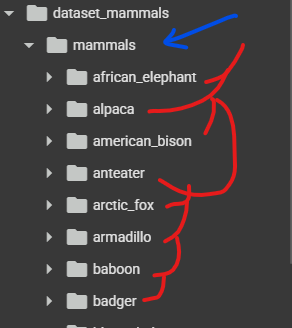

the blue arrow represent the folder of the extracted content, so the root of this dataset is *mammals* not *dataset_mammals*

In [9]:
mammals_dataset_root = extracted_mammal_dataset_path / 'mammals'
print(f"mammals dataset root: {mammals_dataset_root}")

mammals dataset root: dataset_mammals/mammals


### Let see the data structure looks like

so how can we visualize the images?

- we used matplotlib `plt.imshow()`: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

so lets get the image path list. this is easily be done using Path instance method `.glob()`

In [10]:
import PIL
import matplotlib.pyplot as plt
from pathlib import Path

#basically we get the all path that follow this structure */*/*.jpg, -> e.g  mammals/alpaca/alpaca-0006.jpg
img_path_list = list(extracted_mammal_dataset_path.glob('*/*/*jpg'))

print('Let see what is impg_path_list:')
img_path_list

Let see what is impg_path_list:


[PosixPath('dataset_mammals/mammals/orangutan/orangutan-0049.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0080.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0332.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0305.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0110.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0027.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0186.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0201.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0040.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0174.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0307.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0172.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0071.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/orangutan-0066.jpg'),
 PosixPath('dataset_mammals/mammals/orangutan/or

#### Basic Concept on How to Use Matplotlib

In matplotlib (usually imported as `plt`):

1. When we plot something, it will appear on the same figure as long as we don't call `plt.show()`.

2. There are two main ways to create plots. One way is using subplots like this: `plt.subplot(nrows, ncols, plot_number)`.

3. To show an image, use `plt.imshow(image_or_numpy, cmap)`. It can accept a PIL image or a NumPy array.  
  - `cmap` is used to control the color mapping. Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

4. To add text:
  - `plt.title()` sets the plot title ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html
  - `plt.xlabel()` sets the x-axis label ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html
  - `plt.ylabel()` sets the y-axis label ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html  
  - `plt.legend()` shows the legend ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html


5. Finally, call `plt.show()` to display the plot. In Jupyter Notebooks, plots might show automatically, but it's good practice to use `plt.show()` just in case it doesn't.


Total images 182 images
full path dataset_mammals/mammals/orangutan/orangutan-0027.jpg
class label: orangutan
see what is pil image <PIL.Image.Image image mode=RGB size=256x256 at 0x7C5B4AAE9D50>


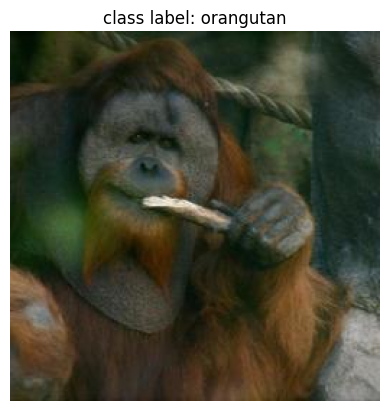

In [11]:
from PIL import Image #we need to import this because? plt only accept PIL image format data or numpy


#recalled back how list work, how we get the element inside it, e.g list_var[0] -> getting first element, if we want to get total of element we used len()
print(f'Total images {len(img_path_list)} images')

#get image path
image_idx = 5 #getting the image at 5 index, you can change to whatever number image you want
sample_image = img_path_list[image_idx]
print(f"full path {sample_image}")
print(f"class label: {sample_image.parent.stem}") # e.g utm_learn_pytorch_dataset/dataset_mammals/mammals/wombat/wombat-0055.jpg,
# .parent get the parent path -> utm_learn_pytorch_dataset/dataset_mammals/mammals/wombat/, .stem only the get the name -> wombat

# lets visualize it
#since plt only accpet PIL image/ numpy so we need to use path to get the PIL image
with Image.open(sample_image) as pilImage:
  sample_pil_image = pilImage.copy()

print(f"see what is pil image {sample_pil_image}")

#used plt.imshow()
plt.imshow(sample_pil_image)
plt.title(f'class label: {sample_image.parent.stem}')
plt.axis(False)
plt.show()



## Lets create Dataset and Dataloader


since this is vision problem (image data), we can used `torchvision` built-in fn. so to used built in dataset function like `torchvision.datasets.ImageFolder` we need to make our data folder structure like this 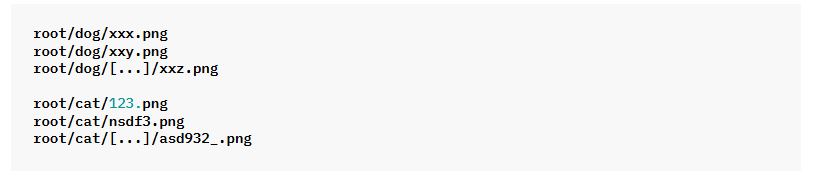


so in this case the root folder is *mammals* so we used variable `mammals_dataset_root`

In [12]:
mammals_dataset_root

PosixPath('dataset_mammals/mammals')

### Create transform for resize the image and convert the image to numerical value

In [13]:
from torchvision.transforms import v2


#create compose of transform step
mammals_transforms = v2.Compose(transforms=[
    v2.ToImage(),
    v2.Resize(size=[64, 64]), #https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.Resize.html
    v2.ToDtype(dtype=torch.float, scale=True),
])

## Create dataset

So, this `Dataset` instances helps us get our information ready for PyTorch. This way, PyTorch can easily take the data for things like making batches and mixing it up (shuffling).

Sometimes, our data isnt set up the way PyTorch expects. When that happens, how do we make sure PyTorch gets the right data for batching, shuffling, and processing to train our model? Thats exactly why we need to change our data into a format PyTorch can work with. We do this by creating `Dataset` instances.

In [14]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
mammals_dataset = ImageFolder("dataset_mammals/mammals", transform=mammals_transforms)

print("Classes:", mammals_dataset.classes)
print("num Classes:", len(mammals_dataset.classes))
print("Samples:", len(mammals_dataset))

Classes: ['horse', 'orangutan', 'zebra']
num Classes: 3
Samples: 182


### Mapping Model Output to Class Labels

lets create a `className` variable. This will help us convert the class index to a readable label.

Usually, the output from a classification model is just an integer number, which represents the class index.

For example, if we have 2 labels: ```className = ['cat', 'dog']```

That means we have 2 class labels — `'cat'` and `'dog'`. The model will output either `0` or `1` (after using `.argmax()` to get the predicted class).

So if the model predicts `0` for the first image, we can get the actual label using: ```className[0]  # returns 'cat'```




In [15]:
mammals_className = mammals_dataset.classes

so usually since if we used pytorch built in  function `ImageFolder`, it has extra attribute or methods attach to it. So let see what are the extra functions...

In [16]:
print(f"{mammals_dataset}\n")
print(f"{mammals_dataset.classes}")
print(f"{len(mammals_dataset)}")
print(f"{len(mammals_dataset.class_to_idx)}")
print("lets get iter using index:")
print(f"how many content when we iter at 0 idx {len(mammals_dataset[0])}")
print(f"{mammals_dataset[0]}")

Dataset ImageFolder
    Number of datapoints: 182
    Root location: dataset_mammals/mammals
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
           )

['horse', 'orangutan', 'zebra']
182
3
lets get iter using index:
how many content when we iter at 0 idx 2
(Image([[[0.5137, 0.5294, 0.5412,  ..., 0.6196, 0.6275, 0.6196],
        [0.5412, 0.5529, 0.5686,  ..., 0.6314, 0.6275, 0.6235],
        [0.5804, 0.5843, 0.5961,  ..., 0.6431, 0.6353, 0.6314],
        ...,
        [0.5765, 0.5490, 0.4980,  ..., 0.6118, 0.6118, 0.6157],
        [0.6000, 0.5725, 0.5333,  ..., 0.6078, 0.6039, 0.6196],
        [0.6353, 0.6510, 0.6353,  ..., 0.5961, 0.6275, 0.5922]],

       [[0.5725, 0.5882, 0.6000,  ..., 0.6353, 0.6431, 0.6353],
        [0.5843, 0.6000, 0.6157,  ..., 0.6549, 0.6510, 0.6471],
        [0.6039, 0.6078, 0.6196,  ..., 0.6745, 0.6667, 0

### Data splitting

When working with machine learning, we usually split the data into **train** and **test** sets — often something like 80% for training and 20% for testing.

But in many tutorials, especially with PyTorch, the 'test' set is actually used during training to check how the model is doing. That’s really what we call a **validation set**.

In real projects, we sometimes see 3 set (but not necessarily, sometimes just 2 one for train and one for model validation):

* **Train set** – for training the model
* **Validation set** – for checking performance during training and tuning things like learning rate
* **Test set** – for final evaluation, after training is done

So if you see 'test' in some PyTorch examples, just remember it might be acting like a validation set.

In [17]:
import torch
from torch.utils.data.dataset import random_split #https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split
#Let create split 80% train and 20% test

#first we get the total dataset
mammals_total_sample = len(mammals_dataset) #this is total dataset
train_split = 0.8
mammals_total_train_split = round(mammals_total_sample * train_split) #we multiply -> get the 80% from total dataset -> 2185
mammals_total_test_split = mammals_total_sample - mammals_total_train_split # -> 546

#set seed for random split
generator1 = torch.Generator().manual_seed(42)
[mammals_train_dataset, mammals_test_dataset] = random_split(mammals_dataset, [mammals_total_train_split, mammals_total_test_split], generator=generator1) #split shuffle 80%

print(f'train split: {len(mammals_train_dataset)}')
print(f'test split: {len(mammals_test_dataset)}')

train split: 146
test split: 36


## Create Dataloader

so after create dataset, we cant feed whole data to our model for training, because if we do that we going to need alot of computing resources. so we need to break down into smaller group (batch).


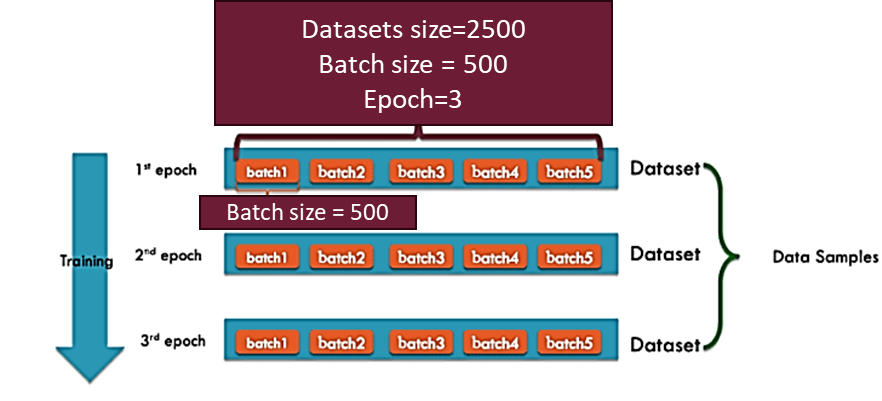

In [18]:
from torch.utils.data import DataLoader

#seed
torch.manual_seed(42)

#create dataloader
BATCH_SIZE = 32
mammals_train_dataloader = DataLoader(mammals_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mammals_test_dataloader = DataLoader(mammals_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#let see how many group per set
print(f"mammals train number of batch: {len(mammals_train_dataloader)}")
print(f"mammals test number of batch: {len(mammals_test_dataloader)}")


#let see how many for images per batch
print(f"mammals number of images per batch: {len(next(iter(mammals_train_dataloader))[0])}")

#so per batch the data is like ->  (images, labels)  where:
# images: tensor of shape [32, C, H, W]
# labels: tensor of shape [32]



mammals train number of batch: 5
mammals test number of batch: 2
mammals number of images per batch: 32


In [19]:
#so lets visualize it how the data batch looks like looks like
test_32_images, test_32_labels = next(iter(mammals_train_dataloader))

print("test 32 images shape: ", test_32_images.shape)
print("test 32 images shape: ", test_32_labels.shape)

test 32 images shape:  torch.Size([32, 3, 64, 64])
test 32 images shape:  torch.Size([32])


## Loss Functions

In this lesson, we’ll build two models, so we need to create separate loss function for each:
- One from scratch
- One using a pretrained model (transfer learning)


For **classification problems** we usually used: -
1. `nn.CrossEntropyLoss()` — used for **multiclass classification** (e.g. cat, dog, bird)
2. `nn.BCEWithLogitsLoss()` — used for **binary classification** (e.g. cat vs not-cat)

*Note: `BCEWithLogitsLoss` includes the sigmoid activation internally, so you don't need to apply it before the loss.*

For **regression problems** we usually used: -
1. `nn.MSELoss()` — **Mean Squared Error**, commonly used
2. `nn.L1Loss()` — **Mean Absolute Error**, less sensitive to outliers


for more refer: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

In [20]:
import torch
from torch import nn

# loss fn for model from scratch
loss_fn_0 = nn.CrossEntropyLoss()

#loss fn for model using pretrained
loss_fn_1 = nn.CrossEntropyLoss()



###  [CHALLENGE] WRITE CODE TOGETHER

## Create model

### Create from scratch


Since this is a vision-based problem and we use images as input, it's generally better to use deep learning, especially CNNs (Convolutional Neural Networks). For more visual understanding: https://poloclub.github.io/cnn-explainer/

To create a model from scratch in PyTorch, we define a class that inherits from `torch.nn.Module`. In Python, creating a class means we need a constructor method like `__init__`. But for PyTorch specifically, we also need to define a method called `forward`.

It's important to get the method name exactly right — `forward` — because PyTorch internally calls this method during training and inference.



for cnn, these are the typical layers that ppl generally use, but not limited to this:

1. `nn.Conv2d()`
2. `nn.ReLU()`
3. `nn.Dropout()`
5. `nn.Flatten()`
4. `nn.Linear()`
5. `nn.MaxPool2d()`
6. `nn.AvgPool2d()`

for more layers refer :https://docs.pytorch.org/docs/stable/nn.html
you are feel free to used other layer from the provided resources, generally in ML we need to try test and experiment abit with various layers or configuration.

In [21]:
import torch
from torch import nn



#create our first model from scratch
class myCNN(nn.Module):
  def __init__(self, input_channel, output_channel, hidden_units):
    super().__init__() #this is important for our class to inherit NN.Module, if you want to create model using pytorch class make sure to write this

    #init layers
    #below we used nn.Sequential
    self.conv2d_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channel,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  padding=0,
                  stride=1),
        nn.ReLU(),
    )
    self.conv2d_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3,3), padding=0, stride=1),
        nn.ReLU(),
    )

    #flatten layer
    self.flatten = nn.Flatten()

    # we do classifier, we need to check dimension if it fit or not first
    self.classifier =nn.Linear(
                  # in_features=hidden_units, #TODO uncomment this originally
                  in_features=hidden_units*60*60, #TODO Correct one
                  out_features=output_channel
                  )

  #this forward method is the method that pytorch will call internally during training
  def forward(self, x):
    # print(f"x data shape: {x.shape}")

    z = self.conv2d_layer_1(x) #x is the data, first we pass to conv2d_layer1
    # print(f"z shape after conv2d_layer_1: {z.shape}")

    z = self.conv2d_layer_2(z) #z is the data after pass conv2d_layer_1, then we pass to conv2d_layer_2
    # print(f"z  shape after conv2d_layer_2: {z.shape}")

    z = self.flatten(z) #z is the data after pass conv2d_layer_2, we pass to flatten layer to flat it
    # print(f"z  shape after flatten layer: {z.shape}")


    z = self.classifier(z)

    return z #we return the output











#### Determine correct Shape after pass thorugh the conv2d layer

In [22]:
#lets figure out what the correct shape?
testCNN = myCNN(input_channel=3, #represent RGB 3D
                output_channel=len(mammals_className),
                hidden_units=16)


#see the how our architecture
testCNN

myCNN(
  (conv2d_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv2d_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=57600, out_features=3, bias=True)
)

Fix correct dimension.
to do that we usually just do 1 time forward pass then check if it correct or not.

In [23]:
#we get any single images just for forward pass
testDataImage, testDataLabel = mammals_dataset[0]
print(f' originally: {testDataImage.shape}') #shape (c, h, w)
print(f"{testDataImage}")



 originally: torch.Size([3, 64, 64])
Image([[[0.5137, 0.5294, 0.5412,  ..., 0.6196, 0.6275, 0.6196],
        [0.5412, 0.5529, 0.5686,  ..., 0.6314, 0.6275, 0.6235],
        [0.5804, 0.5843, 0.5961,  ..., 0.6431, 0.6353, 0.6314],
        ...,
        [0.5765, 0.5490, 0.4980,  ..., 0.6118, 0.6118, 0.6157],
        [0.6000, 0.5725, 0.5333,  ..., 0.6078, 0.6039, 0.6196],
        [0.6353, 0.6510, 0.6353,  ..., 0.5961, 0.6275, 0.5922]],

       [[0.5725, 0.5882, 0.6000,  ..., 0.6353, 0.6431, 0.6353],
        [0.5843, 0.6000, 0.6157,  ..., 0.6549, 0.6510, 0.6471],
        [0.6039, 0.6078, 0.6196,  ..., 0.6745, 0.6667, 0.6627],
        ...,
        [0.5608, 0.5373, 0.4941,  ..., 0.5961, 0.6000, 0.6039],
        [0.5725, 0.5569, 0.5176,  ..., 0.5922, 0.5922, 0.6078],
        [0.6078, 0.6275, 0.6157,  ..., 0.5804, 0.6157, 0.5804]],

       [[0.6706, 0.6902, 0.6980,  ..., 0.7569, 0.7647, 0.7569],
        [0.6902, 0.7020, 0.7176,  ..., 0.7490, 0.7451, 0.7451],
        [0.7176, 0.7176, 0.7294,  ...

In [24]:
# as you can see the shape is only 3 dim (C, H, W) -> (3, 64, 64)
#but for passing forward pass we need to have shape like this (B, C, H, W) B for batch,
#which represent number of batch, and since this is only single iamge so batch is 1,
#so we need to have like this shape (1, 3, 64, 64)

# we can do that bu sing method .unsqueeze(dim=0), dim=0 refer to dimension to add singleton
testDataImage = testDataImage.unsqueeze(dim=0)

print(f"after unsqueeze: {testDataImage.shape}")

after unsqueeze: torch.Size([1, 3, 64, 64])


In [25]:
import torch

testCNN.eval() #this to disable dropout
with torch.inference_mode():
  testPredLabel = testCNN(testDataImage)


#### Create/instantiate our First model from scratch


In [26]:
#seed
torch.manual_seed(42)

#instantiate model
model_0 = myCNN(input_channel=3,
                output_channel=len(mammals_className),
                hidden_units=16 #for this calss we used lower number of hidden units
                ).to(device)

model_0

myCNN(
  (conv2d_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv2d_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=57600, out_features=3, bias=True)
)

### [CHALLENGE] (WRITE CODE TOGETHER)

## Create Train and Test step function

### Create Train Step

to create train step, you need to do
1.  optimizer.zero_grad()
2.  forward pass (pass the data to the model, essentailly let the model see the data and make prediction)
3. calculate the loss function (see how much diff the prediction than the target)
4.  Backward pass (calculate the gradient descent)
5. Step up, (change to the new weight value),

> How do we get the new weight value?
> First, we get the gradient of the loss.
> If the gradient is 0, it could mean we are at a minimum, maximum, or a flat point.
> But since we want to **minimize the loss**, the model keeps updating the weights to move in the direction that makes the loss smaller.
>
> We use the gradient to decide:
>
> * If the gradient is **negative**, we **increase** the weight
> * If the gradient is **positive**, we **decrease** the weight
>
> This helps the model move toward the lowest loss (minimum).



In [27]:
#this is for learning
def train_step(model,
               train_dataloader,
               optimizer,
               loss_fn, device=device):

  #transfer the mode to device
  model.to(device)

  #set to train
  model.train()

  #metrics
  total_loss = 0
  total_accuracy = 0

  #loop for each batch
  for i, (X, y) in enumerate(train_dataloader):
    #transfer to device
    X = X.to(device)
    y = y.to(device)

    #zero grad() clear any previous gradient
    optimizer.zero_grad()

    #forward pass
    y_logit = model(X)
    y_pred_label = y_logit.argmax(dim=1)

    #calculate the loss
    loss_per_batch = loss_fn(y_logit, y)

    #calculate the loss per epoch
    total_loss +=  loss_per_batch.item()

    #get the accuracy
    accuracy_per_batch = (y == y_pred_label).sum().item()/len(y)
    total_accuracy +=  accuracy_per_batch

    #loss backward() gradient descent
    loss_per_batch.backward()

    #step up
    optimizer.step()

  #calculate per average
  avg_loss = total_loss / len(train_dataloader)
  avg_accuracy = total_accuracy / len(train_dataloader)

  return avg_loss, avg_accuracy






#### [CHALLENGE] WRITE CODE TOGETHER

### Create Test step



To create a test (evaluation) step, you need:

1. **Set the model to evaluation mode**  
  Use `model.eval()` — this is important to turn off layers like **dropout** and **batch normalization**, so the model behaves correctly during evaluation.

2. **Use inference mode**  
  Use `with torch.inference_mode():` — this stops PyTorch from tracking gradients, which saves memory and speeds up evaluation. It also avoids accidentally using this computation for backpropagation.


In [28]:
def test_step(model,
              loss_fn,
              test_dataloader, device=device):

  #transfer the mode to device
  model.to(device)

  #set model to eval
  model.eval() #disable all the dropout

  #metrics
  total_test_loss = 0
  total_test_accuracy = 0

  with torch.inference_mode(): # turns off gradient tracking during prediction
    #iterate test dataloader
    for X_test, y_test in test_dataloader:
      #transfer device
      X_test = X_test.to(device)
      y_test = y_test.to(device)


      #forward pass
      y_test_logit = model(X_test)
      y_test_pred = y_test_logit.argmax(dim=1)

      #calculate the loss
      test_loss_per_batch = loss_fn(y_test_logit, y_test)
      total_test_loss += test_loss_per_batch.item()

      #calculate the accuracy
      test_accuracy_per_batch = (y_test_pred == y_test).sum().item()/len(y_test)
      total_test_accuracy += test_accuracy_per_batch

  #get average
  test_avg_loss = total_test_loss/len(test_dataloader)
  test_avg_accuracy = total_test_accuracy/len(test_dataloader)

  return test_avg_loss, test_avg_accuracy

#### [CHALLENGE] WRITE CODE TOGETHER

### Combine all the train and test step

this is important since usually for training we need to pass numerous time of the data
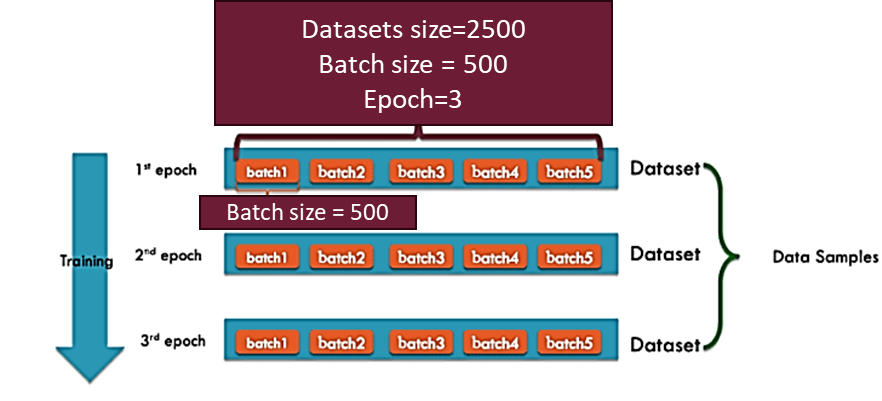

In [29]:
def training(model,
             optimizer,
             loss_fn,
             train_dataloader,
             test_dataloader,
             device=device,
             epochs=5):

  #track epoch loss and accuracy
  loss_epoch = []
  accuracy_epoch = []
  test_loss_epoch = []
  test_accuracy_epoch = []

  #so we set how many iteration/epoch
  for epoch in range(epochs):

    #do train step
    loss, accuracy = train_step(model,
                                train_dataloader=train_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

    #do test step
    test_loss, test_accuracy = test_step(model,
                                         test_dataloader=test_dataloader,
                                         loss_fn=loss_fn,
                                         device=device)

    print(f"Epoch {epoch+1} | Loss: {loss: .4f} | Accuracy: {accuracy: .3f} | Test Loss: {test_loss: .4f} | Test Accuracy: {test_accuracy: .3f}")

    #append
    loss_epoch.append(loss)
    accuracy_epoch.append(accuracy)
    test_loss_epoch.append(test_loss)
    test_accuracy_epoch.append(test_accuracy)

  return {
      "loss": loss_epoch,
      "accuracy": accuracy_epoch,
      "test_loss": test_loss_epoch,
      "test_accuracy": test_accuracy_epoch,
      "epochs": epochs
  }





#### [CHALLENGE] WRITE CODE TOGETHER

## Create optimizer and Training Time!

- again remember that, we already create loss function -> `loss_fn_0`
- The optimizer updates the weights, so the model can reduce the loss in the next step. Since the optimizer is responsible for updating the model's weights, we need to tell it which model parameters to update. So there are many optimizer to used, but optimizer that you commonly see are:
  - SGD (Stochastic gradient Descent)
  - Adam

  However, You are free to used other optimizer, feel free to see it here: https://docs.pytorch.org/docs/stable/optim.html

In [30]:
import torch
from torch import nn

# We already created this above, but we’ll recreate it here
# so we can see the full picture in one place
loss_fn_0 = nn.CrossEntropyLoss()


#Create optimizer
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.001)



#Training
EPOCHS = 10 #set number of epochs
result_model_0 = training(model=model_0,
                          optimizer=optimizer_0,
                          loss_fn=loss_fn_0,
                          train_dataloader=mammals_train_dataloader,
                          test_dataloader=mammals_test_dataloader,
                          device=device,
                          epochs=EPOCHS)



Epoch 1 | Loss:  1.0992 | Accuracy:  0.307 | Test Loss:  1.0949 | Test Accuracy:  0.297
Epoch 2 | Loss:  1.0964 | Accuracy:  0.337 | Test Loss:  1.0956 | Test Accuracy:  0.172
Epoch 3 | Loss:  1.0956 | Accuracy:  0.344 | Test Loss:  1.0927 | Test Accuracy:  0.297
Epoch 4 | Loss:  1.0924 | Accuracy:  0.338 | Test Loss:  1.0954 | Test Accuracy:  0.172
Epoch 5 | Loss:  1.0907 | Accuracy:  0.386 | Test Loss:  1.1057 | Test Accuracy:  0.125
Epoch 6 | Loss:  1.0905 | Accuracy:  0.353 | Test Loss:  1.1191 | Test Accuracy:  0.125
Epoch 7 | Loss:  1.0896 | Accuracy:  0.344 | Test Loss:  1.1131 | Test Accuracy:  0.125
Epoch 8 | Loss:  1.0882 | Accuracy:  0.373 | Test Loss:  1.1100 | Test Accuracy:  0.125
Epoch 9 | Loss:  1.0884 | Accuracy:  0.358 | Test Loss:  1.0991 | Test Accuracy:  0.156
Epoch 10 | Loss:  1.0859 | Accuracy:  0.371 | Test Loss:  1.0919 | Test Accuracy:  0.281


### [CHALLENGE] WRITE CODE TOGETHER

As you can see, the accuracy is very low. This is because:

1. In this class, we’re only using 20% of the dataset (around 2,000 images)
2. We built the model from scratch, and it has never seen any images before. It needs a lot more data and a deeper model (ours only has 2 convolutional layers and 1 classifier head).

So, how can we improve the accuracy?
1. Increase the size of the dataset
2. Use a pretrained model — a model that has already been trained on many images and is more familiar with visual features



## Using pretrained model (transfer learning)

As we can see, when we build a model from scratch, it requires a lot of images to train.
Since the model has never seen any images before, it doesn't recognize what's in the image —> especially for things like animals, objects, etc.

This is why training from scratch can be hard for general image tasks.

However, if our data is something simpler  like black and white crack surfaces therefore training from scratch might still work because the patterns are more basic.

But if we use a pretrained model (a model that has already seen and learned from millions of images), and apply transfer learning with our own dataset, it usually performs much better — even with less data.


For this class, we going to used MobileNetV2, however you are free to check or test with other model refer here: https://docs.pytorch.org/vision/main/models.html

### Get/Load pretrained model

In [31]:
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2

#seed
torch.manual_seed(42)


#load the mobilenet v2 model
model_pretrained_0 = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to(device)

model_pretrained_0

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.0MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### [CHALLENGE] WRITE CODE TOGETHER

### Transform data follow the pretrained transformation

Since we're using a pretrained model, it's better to transform the input data (like resize and normalize) to match the transforms used during MobileNet training., so to get the transform we access the transform from `MobileNet_V2_Weights.DEFAULT.transforms()`

In [32]:
#let see whats MobileNet_V2_Weights.DEFAULT.transforms()
auto_transform = MobileNet_V2_Weights.DEFAULT.transforms()

auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [33]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data.dataset import random_split #https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split


# pretrained
mammals_dataset_pretrained = ImageFolder("dataset_mammals/mammals", transform=auto_transform) #this is where we transformed the data


#Below is the same thing that we already did earlier 9it just for split 80-20 data
#set seed for random split
generator1 = torch.Generator().manual_seed(42)
[mammals_train_dataset_pretrained, mammals_test_dataset_pretrained] = random_split(mammals_dataset_pretrained, [mammals_total_train_split, mammals_total_test_split], generator=generator1)


print(f"train {len(mammals_train_dataset_pretrained)}")
print(f"test {len(mammals_test_dataset_pretrained)}")

train 146
test 36


In [34]:
mammals_train_dataset_pretrained[0][0].shape

torch.Size([3, 224, 224])

Since we created a new dataset with new transforms, we also need to create a new DataLoader for it.

In [35]:
#batch size
BATCH_SIZE = 32 # same as earlier

#seed
torch.manual_seed(42)


mammals_train_dataloader_pretrained = DataLoader(mammals_train_dataset_pretrained, batch_size=BATCH_SIZE, shuffle=True) #train dataloader for pretrained model
mammals_test_dataloader_pretrained = DataLoader(mammals_test_dataset_pretrained, batch_size=BATCH_SIZE, shuffle=True) #test dataloader for pretrained model


print(len(mammals_train_dataloader_pretrained))
print(len(mammals_test_dataloader_pretrained))

5
2


### Lets check how the model structure looks like

in this, we use `torchinfo` to check a summary of the pretrained model's architecture. But `torchinfo` is not preinstalled in colab so we need to install torchinfo manually. For more refer :https://github.com/TylerYep/torchinfo

In [36]:
!pip install torchinfo

lets print the summary using `torchinfo`

In [37]:
from torchinfo import summary

summary(model_pretrained_0, input_size=[1, 3, 224, 224], col_names=['input_size', 'output_size', 'trainable', "num_params"], row_settings=['var_names'])

Layer (type (var_name))                       Input Shape               Output Shape              Trainable                 Param #
MobileNetV2 (MobileNetV2)                     [1, 3, 224, 224]          [1, 1000]                 True                      --
├─Sequential (features)                       [1, 3, 224, 224]          [1, 1280, 7, 7]           True                      --
│    └─Conv2dNormActivation (0)               [1, 3, 224, 224]          [1, 32, 112, 112]         True                      --
│    │    └─Conv2d (0)                        [1, 3, 224, 224]          [1, 32, 112, 112]         True                      864
│    │    └─BatchNorm2d (1)                   [1, 32, 112, 112]         [1, 32, 112, 112]         True                      64
│    │    └─ReLU6 (2)                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual (1)                   [1, 32, 112, 112]         [1, 16, 112, 112]         True   

From above, you can see there are two main parts (layers) in the model.
  - First, the `features` part — this acts as a feature extractor. It mainly consists of convolutional layers that help extract patterns like edges, shapes, and textures.

  - Second, the `classifier` — this part is responsible for predicting the class label based on the features extracted earlier.

### Freeze the Feature Extractor and Change the Classifier to Fit Our Problem

The feature extractor is the part of the model that learns to detect shapes, edges, and visual patterns.  
Since it has already learned useful features from a large dataset (like ImageNet), we usually (but not always) freeze it — meaning we don't update its weights during training. This helps save training time and works well if your data is similar to ImageNet.

However, if your dataset is very different or large enough, you can choose to **fine-tune** the whole model instead of freezing.

What we do want to change is the **classifier head**.  
The original model was trained with 1,000 output classes (for ImageNet), but our dataset only has 45 labels.  
So we replace the classifier layer to output 45 classes to match our task.


In [38]:
#lets freeze the feature extractor
for param in model_pretrained_0.features.parameters():
  param.requires_grad = False

summary(model_pretrained_0, input_size=[1, 3, 224, 224], col_names=['input_size', 'output_size', 'trainable', "num_params"], row_settings=['var_names'])

Layer (type (var_name))                       Input Shape               Output Shape              Trainable                 Param #
MobileNetV2 (MobileNetV2)                     [1, 3, 224, 224]          [1, 1000]                 Partial                   --
├─Sequential (features)                       [1, 3, 224, 224]          [1, 1280, 7, 7]           False                     --
│    └─Conv2dNormActivation (0)               [1, 3, 224, 224]          [1, 32, 112, 112]         False                     --
│    │    └─Conv2d (0)                        [1, 3, 224, 224]          [1, 32, 112, 112]         False                     (864)
│    │    └─BatchNorm2d (1)                   [1, 32, 112, 112]         [1, 32, 112, 112]         False                     (64)
│    │    └─ReLU6 (2)                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual (1)                   [1, 32, 112, 112]         [1, 16, 112, 112]         Fal

In [39]:
#then we change the classifier head, but we only want to change the very last layer
print(model_pretrained_0.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [40]:
#as you can see above, the only thing that we want to make changes is the Linear
#the linear have in_features=1280, and out_features=1000 (1k because it have 1k label)
#but our data only have 45 label so we need to change that

new_classifier_layer = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                     nn.Linear(in_features=1280, out_features=len(mammals_className))).to(device) #make sure to move to same device


#replace the last layer of the pretrained model
model_pretrained_0.classifier = new_classifier_layer


summary(model_pretrained_0, input_size=[1, 3, 224, 224], col_names=['input_size', 'output_size', 'trainable', "num_params"], row_settings=['var_names'])

Layer (type (var_name))                       Input Shape               Output Shape              Trainable                 Param #
MobileNetV2 (MobileNetV2)                     [1, 3, 224, 224]          [1, 3]                    Partial                   --
├─Sequential (features)                       [1, 3, 224, 224]          [1, 1280, 7, 7]           False                     --
│    └─Conv2dNormActivation (0)               [1, 3, 224, 224]          [1, 32, 112, 112]         False                     --
│    │    └─Conv2d (0)                        [1, 3, 224, 224]          [1, 32, 112, 112]         False                     (864)
│    │    └─BatchNorm2d (1)                   [1, 32, 112, 112]         [1, 32, 112, 112]         False                     (64)
│    │    └─ReLU6 (2)                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual (1)                   [1, 32, 112, 112]         [1, 16, 112, 112]         Fal

#### [CHALLENGE] WRITE CODE TOGETHER

### Traning our pretrained model

recalled back for training what we need?
1. loss function
2. optimizer

In [41]:

#loss function
loss_fn_1 = nn.CrossEntropyLoss()

#optimizer
optimizer_1 = torch.optim.SGD(params=model_pretrained_0.parameters(), lr=0.001)


#training
EPOCHS = 10
result_model_1 = training(model=model_pretrained_0,
                          train_dataloader=mammals_train_dataloader_pretrained,
                          test_dataloader=mammals_test_dataloader_pretrained,
                          loss_fn=loss_fn_1,
                          optimizer=optimizer_1,
                          epochs=EPOCHS,
                          device=device)

Epoch 1 | Loss:  1.0784 | Accuracy:  0.363 | Test Loss:  1.1212 | Test Accuracy:  0.234
Epoch 2 | Loss:  1.0519 | Accuracy:  0.459 | Test Loss:  1.0952 | Test Accuracy:  0.172
Epoch 3 | Loss:  1.0369 | Accuracy:  0.538 | Test Loss:  1.0367 | Test Accuracy:  0.375
Epoch 4 | Loss:  1.0185 | Accuracy:  0.588 | Test Loss:  1.0902 | Test Accuracy:  0.172
Epoch 5 | Loss:  1.0044 | Accuracy:  0.636 | Test Loss:  1.0070 | Test Accuracy:  0.578
Epoch 6 | Loss:  0.9862 | Accuracy:  0.635 | Test Loss:  1.0404 | Test Accuracy:  0.516
Epoch 7 | Loss:  0.9693 | Accuracy:  0.667 | Test Loss:  1.0627 | Test Accuracy:  0.422
Epoch 8 | Loss:  0.9686 | Accuracy:  0.701 | Test Loss:  1.0733 | Test Accuracy:  0.547
Epoch 9 | Loss:  0.9595 | Accuracy:  0.708 | Test Loss:  1.0097 | Test Accuracy:  0.656
Epoch 10 | Loss:  0.9432 | Accuracy:  0.778 | Test Loss:  0.9588 | Test Accuracy:  0.688


#### [CHALLENGE] WRITE CODE TOGETHER

## Plot loss and accuracy

lets plot loss and accuracy for each model

In [42]:
import matplotlib.pyplot as plt

#Helper function plot loss acc
def plot_loss_acc(result, title=''):
  #get epoch range
  epochs_range = list(range(result['epochs']))

  #plot figure
  plt.figure(figsize=(12, 6))

  #gives title name
  plt.suptitle(title)


  #plot loss
  plt.subplot(1,2,1) #(nrows, ncols, positionPlot)
  plt.plot(epochs_range, result["test_loss"], label='test_loss')
  plt.plot(epochs_range, result["loss"], label='test_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  #plot acc
  plt.subplot(1,2,2) #(nrows, ncols, positionPlot)
  plt.plot(epochs_range, result["test_accuracy"], label='test_accuracy')
  plt.plot(epochs_range, result["accuracy"], label='test_accuracy')
  plt.xlabel('accuracy')
  plt.ylabel('Loss')

  #conf
  plt.legend()
  plt.show()



### Model built from scratch

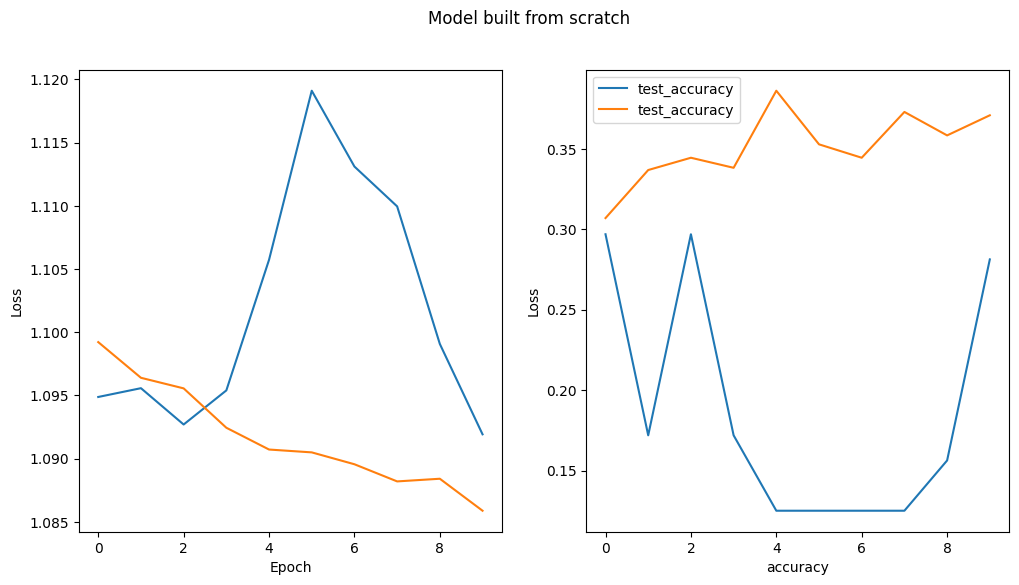

In [43]:
plot_loss_acc(result_model_0, title='Model built from scratch')

### Pretrained model

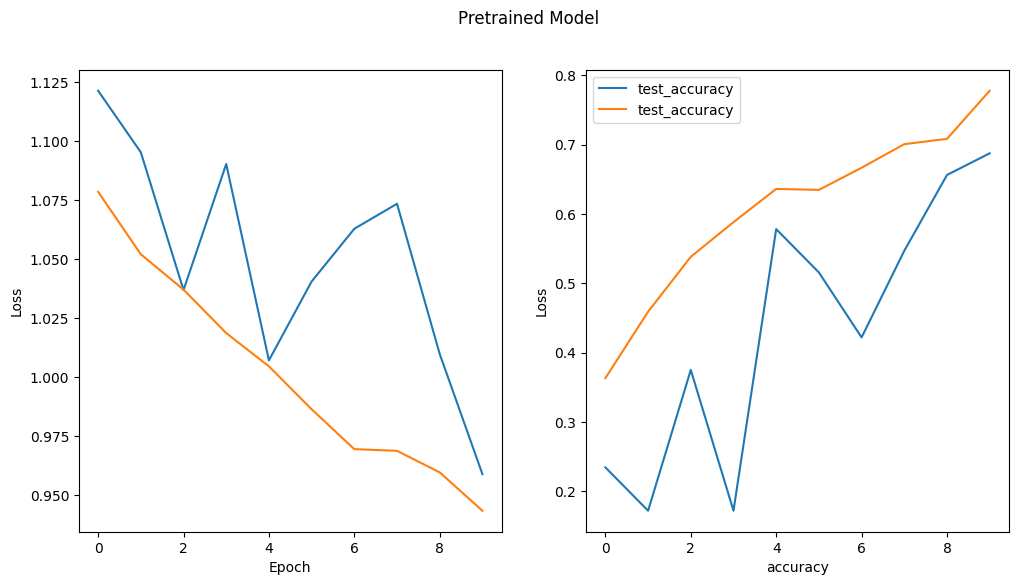

In [44]:
plot_loss_acc(result_model_1, title='Pretrained Model')

# 2nd handson: Working with numerical dataset (NASA Airfoil Self-Noise Dataset)

this second hands one we used dataset from: https://www.kaggle.com/datasets/fedesoriano/airfoil-selfnoise-dataset

  
  Input features:

    - f: Frequency in Hertzs [Hz].
    - alpha: Angle of attack (AoA, α), in degrees [°].
    - c: Chord length, in meters [m].
    - U_infinity: Free-stream velocity, in meters per second [m/s].
    - delta: Suction side displacement thickness (𝛿), in meters [m].

  Output:

    - SSPL: Scaled sound pressure level, in decibels [dB].

## Getting/downloading the dataset to this colab

In [45]:
noise_csv_path = download_file('https://drive.google.com/file/d/1XNyCBkg-pBwesGZMqh8HbbbZaN24ftfa/view?usp=drive_link', 'AirfoilSelfNoise.csv')

[INFO] Downloading AirfoilSelfNoise.csv...


Downloading...
From: https://drive.google.com/uc?id=1XNyCBkg-pBwesGZMqh8HbbbZaN24ftfa
To: /content/AirfoilSelfNoise.csv
100%|██████████| 59.9k/59.9k [00:00<00:00, 42.4MB/s]

[INFO] Done download at .


## Convert the data to dataframe

In [46]:
import pandas as pd

#convert to dataframe
noise_df = pd.read_csv(noise_csv_path)

noise_df

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [47]:
#let see what are the inputs
noise_df.iloc[:, :-1]

,f,alpha,c,U_infinity,delta
0,800,0.0,0.3048,71.3,0.002663
1,1000,0.0,0.3048,71.3,0.002663
2,1250,0.0,0.3048,71.3,0.002663
3,1600,0.0,0.3048,71.3,0.002663
4,2000,0.0,0.3048,71.3,0.002663
...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849
1499,3150,15.6,0.1016,39.6,0.052849
1500,4000,15.6,0.1016,39.6,0.052849
1501,5000,15.6,0.1016,39.6,0.052849


In [48]:
#let see the output (target)
noise_df.iloc[:, -1]

,SSPL
0,126.201
1,125.201
2,125.951
3,127.591
4,127.461
...,...
1498,110.264
1499,109.254
1500,106.604
1501,106.224


In [49]:
# Check the data types of each column in the DataFrame
noise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f           1503 non-null   int64  
 1   alpha       1503 non-null   float64
 2   c           1503 non-null   float64
 3   U_infinity  1503 non-null   float64
 4   delta       1503 non-null   float64
 5   SSPL        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [50]:
# See how many samples the data has
noise_df['SSPL'].count()

np.int64(1503)

calculate the std mean etc, for normalize the data


In [51]:
#calculate mean,std, ..etc
noise_df.describe()

,f,alpha,c,U_infinity,delta,SSPL
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Creating Dataset

As we can see this is not Image Dataset, so we cant used pytorch builtIn function, therefor we need to create our own dataset. Refer: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html


In [52]:
from torch.utils.data import Dataset

#create custom dataset
class NoiseDataset(Dataset):
  def __init__(self, df, transform=None):
    super().__init__()

    #create attributes
    self.columns = df.columns
    self.df = df
    self.X = df.iloc[:, :-1]
    self.y = df.iloc[:, -1]

    #calcualte mean and std for normalization
    self.mean = self.X.mean(axis=0)
    self.std = self.X.std(axis=0)

    #normalize
    self.X = (self.X - self.mean)/self.std

    # print(self.X.iloc[idx, :])


  #create __getitem__ dunder method
  def __getitem__(self, idx): #this is required to create our own custom dataset

    return torch.tensor(self.X.iloc[idx, :], dtype=torch.float), torch.tensor(self.y.iloc[idx], dtype=torch.float)

  #create __len__ dunder method
  def __len__(self): #this is required to create our own custom dataset
    return self.y.count()


In [53]:
#instant dataset
noise_dataset = NoiseDataset(noise_df)

len(noise_dataset), noise_dataset[0]

/tmp/ipython-input-52-1561461209.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[idx, :], dtype=torch.float), torch.tensor(self.y.iloc[idx], dtype=torch.float)


(1503,
 (tensor([-0.6618, -1.1460,  1.7987,  1.3125, -0.6446]), tensor(126.2010)))

### Splitting dataset to train test set (80% -20%)


In [54]:
from torch.utils.data.dataset import random_split


#train split
train_split = 0.8 #80%

#lets get total dataset, train_total_split and test_total_split
total_noise_dataset = len(noise_dataset)
noise_total_train_split = round(total_noise_dataset*train_split) #-> 1202
noise_total_test_split = total_noise_dataset - noise_total_train_split #-> 301


#split the dataset
#set seed for random split
generator2 = torch.Generator().manual_seed(42)
[noise_train_dataset, noise_test_dataset] = random_split(noise_dataset, [noise_total_train_split, noise_total_test_split], generator=generator2) #split shuffle 80%

print(f'train split: {len(noise_train_dataset)}')
print(f'test split: {len(noise_test_dataset)}')



train split: 1202
test split: 301


## Create Dataloader

We can't send all the data into the model at once (consume alot of computing resource), so we split it into batches.


In [55]:
from torch.utils.data import DataLoader


#set seed (for reproducibilty)
torch.manual_seed(42)

#batch size
BATCH_SIZE = 32


# train dataloader
noise_train_dataloader = DataLoader(noise_train_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)

# test dataloader
noise_test_dataloader = DataLoader(noise_test_dataset,
                                   batch_size=BATCH_SIZE)

## Build a Simple Deep Learning Model (for Tabular or Non-Image Data)

similar to step in how to build model from scratch, but for this we dont used `nn.Conv2d` just `nn.linear`



In [56]:
import torch
from torch import nn


#this is simple model for training non image dataset
class myNoiseModel(nn.Module):
  def __init__(self, in_shape, out_shape=1, hidden_units=64):
    super().__init__()

    #create layers
    self.classifier = nn.Sequential(
        nn.Linear(in_features=in_shape, out_features=hidden_units),
        nn.ReLU(),
        # nn.Dropout(p=0.2),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        # nn.Dropout(p=0.2),
        nn.Linear(in_features=hidden_units, out_features=out_shape)
    )

  def forward(self, x):
    return self.classifier(x)


Create model instance.
So, how many output classes are there?
 - Just 1, because this is a regression problem, and we're predicting a single continuous value.
 - how many features (input) are there? -> **5** `f`	`alpha`	`c`	`U_infinity`	`delta`

In [57]:
#for reproducibilty
torch.manual_seed(42)


#create model instances
noise_model_0 = myNoiseModel(in_shape=5, out_shape=1, hidden_units=64)

noise_model_0

myNoiseModel(
  (classifier): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Create train and test step for regression

it similar to previous but, for regression we dont calculate accuracy, since we doing regression we only check MSELOSS (for train) and L1 (MAE) loss for testing

In [58]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

#train step
def train_step_regression(model,
                          dataloader,
                          loss_fn,
                          optimizer,
                          device=device):
  model.train()
  train_loss = 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X).squeeze()  # [[a], [b]...] -> to 1d vectro [a,b,...]

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss / len(dataloader)

# Test step
def test_step_regression(model,
                         dataloader,
                         loss_fn, #we not take same loss_fn as train step, because train step used MSE (square error), but when used test it push alot so we just used L1 loss
                         device=device):
  model.eval()
  test_loss = 0

  #create MAELoss
  loss_MAE_Fn = torch.nn.L1Loss()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X).squeeze()

      # loss = loss_fn(y_pred, y) #we not used MSE loss
      loss = loss_MAE_Fn(y_pred, y)

      test_loss += loss.item()

  return test_loss / len(dataloader)

#training step
def train_regression(model: torch.nn.Module,
                     train_dataloader: torch.utils.data.DataLoader,
                     test_dataloader: torch.utils.data.DataLoader,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: torch.nn.Module,
                     epochs: int,
                     device: torch.device) -> Dict[str, List[float]]:
  results = {"train_loss": [], "test_loss": []}

  model.to(device)

  for epoch in tqdm(range(epochs)):
    train_loss = train_step_regression(
      model, train_dataloader, loss_fn, optimizer, device)

    test_loss = test_step_regression(
      model, test_dataloader, loss_fn, device)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)

  return results


## lets Train!


So again when train what we need?
 - loss function
 - optimizer

In [59]:
#create loss
loss_fn_2 = torch.nn.MSELoss()

#create optimizer
optimizer_2 = torch.optim.SGD(params=noise_model_0.parameters(), lr=0.001)


#training
EPOCHS = 100
result_noise_model = train_regression(noise_model_0,
                 noise_train_dataloader,
                 noise_test_dataloader,
                 optimizer=optimizer_2,
                 loss_fn=loss_fn_2,
                 epochs=EPOCHS,
                 device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-52-1561461209.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[idx, :], dtype=torch.float), torch.tensor(self.y.iloc[idx], dtype=torch.float)


Epoch 1 | Train Loss: 4852.0147 | Test Loss: 19.1509
Epoch 2 | Train Loss: 1209.6851 | Test Loss: 15.8612
Epoch 3 | Train Loss: 413.5101 | Test Loss: 8.1034
Epoch 4 | Train Loss: 85.4743 | Test Loss: 5.5751
Epoch 5 | Train Loss: 57.3284 | Test Loss: 6.2874
Epoch 6 | Train Loss: 123.4866 | Test Loss: 11.7383
Epoch 7 | Train Loss: 64.2406 | Test Loss: 8.4916
Epoch 8 | Train Loss: 44.6978 | Test Loss: 7.0782
Epoch 9 | Train Loss: 29.2525 | Test Loss: 5.0448
Epoch 10 | Train Loss: 24.8821 | Test Loss: 3.9414
Epoch 11 | Train Loss: 26.8961 | Test Loss: 5.1461
Epoch 12 | Train Loss: 39.2584 | Test Loss: 3.5596
Epoch 13 | Train Loss: 28.8729 | Test Loss: 3.2772
Epoch 14 | Train Loss: 23.2338 | Test Loss: 5.5962
Epoch 15 | Train Loss: 28.9259 | Test Loss: 6.0436
Epoch 16 | Train Loss: 31.4128 | Test Loss: 7.0691
Epoch 17 | Train Loss: 26.1753 | Test Loss: 4.0198
Epoch 18 | Train Loss: 18.2262 | Test Loss: 3.4574
Epoch 19 | Train Loss: 15.9766 | Test Loss: 2.8922
Epoch 20 | Train Loss: 15.4675 

## Plot Target vs. Predicted

We are going to create a scatter plot showing both the target (actual) and predicted y values on the same graph.



Before we plot, we need the predicted data (y_pred) and the target values.

To recap: when we want to **test** (not train) our model on new data, we need to do a few things:

1. Set the model to evaluation mode using `model.eval()`. This disables layers like dropout and batchnorm that behave differently during training.

2. Perform the forward pass inside a `torch.inference_mode()` context. This disables gradient tracking, which makes inference faster and saves memory.

/tmp/ipython-input-52-1561461209.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[idx, :], dtype=torch.float), torch.tensor(self.y.iloc[idx], dtype=torch.float)


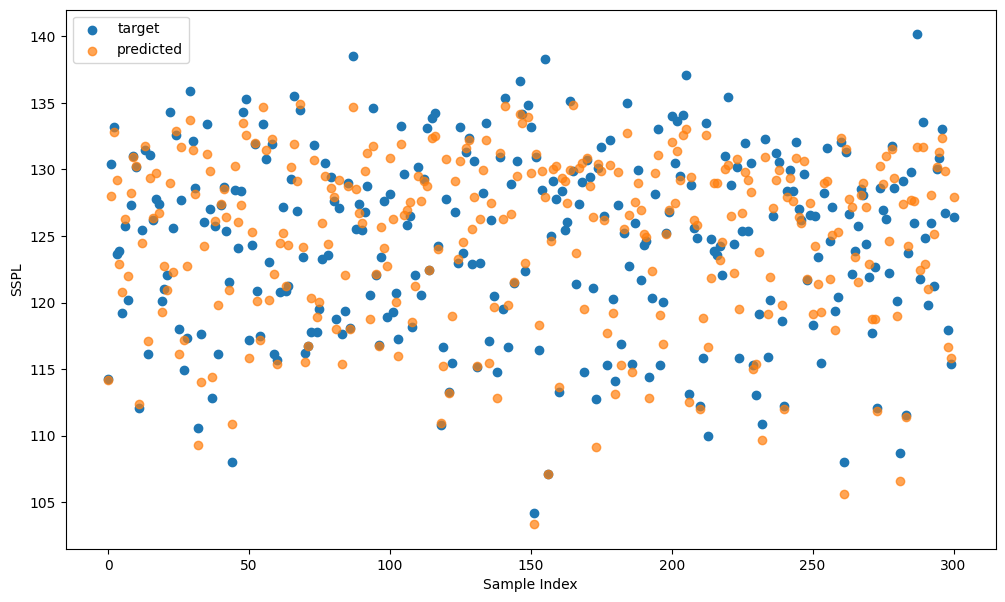

In [60]:
import matplotlib.pyplot as plt

# to storetarget and predicted
target = []
predicted = []



# getting the target and predicted data
# first we get the data from the train dataloader
for X_test, y_test in noise_test_dataloader:
  # again remember since this is not train, we need to set few things!
  #set model `.eval()` , disable any dropout
  noise_model_0.eval()

  #set inference mode, to disable gradient tracking
  with torch.inference_mode():
    #move the model and data to device
    noise_model_0.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    #forward pass (feed the data to our model)
    y_test_pred = noise_model_0(X_test).squeeze() # to convert to 1d, from shape (B, 1) -> (B)

    #append
    predicted.append(y_test_pred)
    target.append(y_test)


#convert list to tensor
target = torch.cat(target).cpu().numpy()
predicted = torch.cat(predicted).cpu().numpy()
rangeSample = list(range(0, len(target)))


#lets plot
plt.figure(figsize=(12,7))
plt.scatter(rangeSample, target,  label='target')
plt.scatter(rangeSample, predicted, label='predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('SSPL')
plt.legend()
plt.show()


